In [1]:
# Problem Statement: Prediction of patients who are likely to miss their medications ( yes or no )

In [2]:
import pandas as pd
import numpy as np
import csv 
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
%matplotlib inline

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
import sklearn as sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis

### Loading data into a Pandas dataframe

In [4]:
df=pd.read_csv('Data.csv')
patient_number = df['patient_id']
df.head()

,patient_id,Age,Gender,Prescription_period,Diabetes,Alcoholism,HyperTension,Smokes,Tuberculosis,Sms_Reminder,Adherence
0,1,19,M,7,0,0,0,0,0,0,No
1,2,24,F,59,0,0,0,0,0,0,No
2,3,4,F,43,0,0,0,0,0,0,No
3,4,38,M,66,0,0,0,0,0,1,No
4,5,46,F,98,0,0,0,0,0,1,No


### No missing Data found (as seen below) but you need to transform features to make them meaningful. Gender and Adherence features have the type of object

In [31]:
print('Rows and columns in dataframe : ',df.shape)

print('\n\nInformation about columns and missingness of data : \n')
print(df.info())

Rows and columns in dataframe :  (180212, 11)


Information about columns and missingness of data : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180212 entries, 0 to 180211
Data columns (total 11 columns):
patient_id             180212 non-null int64
Age                    180212 non-null int64
Gender                 180212 non-null object
Prescription_period    180212 non-null int64
Diabetes               180212 non-null int64
Alcoholism             180212 non-null int64
HyperTension           180212 non-null int64
Smokes                 180212 non-null int64
Tuberculosis           180212 non-null int64
Sms_Reminder           180212 non-null int64
Adherence              180212 non-null object
dtypes: int64(9), object(2)
memory usage: 15.1+ MB
None


In [32]:
df['Adherence'].replace(to_replace = ['No','Yes'], value = [0,1], inplace = True)
df['Gender'].replace(to_replace = ['M','F'], value = [1,0], inplace = True)
df.rename(columns = {'Gender' : 'Male_or_Not'}, inplace = True) #if Male_or_not = 0, then its female
df.drop(['patient_id'] , axis = 1, inplace = True) #dropping patient id , as it gives no value
df.head()

,Age,Male_or_Not,Prescription_period,Diabetes,Alcoholism,HyperTension,Smokes,Tuberculosis,Sms_Reminder,Adherence
0,19,1,7,0,0,0,0,0,0,0
1,24,0,59,0,0,0,0,0,0,0
2,4,0,43,0,0,0,0,0,0,0
3,38,1,66,0,0,0,0,0,1,0
4,46,0,98,0,0,0,0,0,1,0


In [33]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180212 entries, 0 to 180211
Data columns (total 10 columns):
Age                    180212 non-null int64
Male_or_Not            180212 non-null int64
Prescription_period    180212 non-null int64
Diabetes               180212 non-null int64
Alcoholism             180212 non-null int64
HyperTension           180212 non-null int64
Smokes                 180212 non-null int64
Tuberculosis           180212 non-null int64
Sms_Reminder           180212 non-null int64
Adherence              180212 non-null int64
dtypes: int64(10)
memory usage: 13.7 MB
None


In [29]:
new_df = df

# EDA

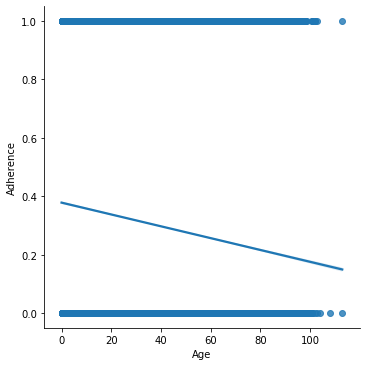

In [8]:
sns.lmplot(y="Adherence", x = 'Age',data=new_df)
# We see a slight trend of more non Adherence when the age of patient is older but this could be due to other features

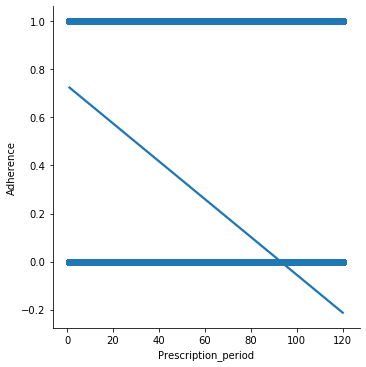

In [9]:
sns.lmplot(y="Adherence", x = 'Prescription_period',data=new_df )

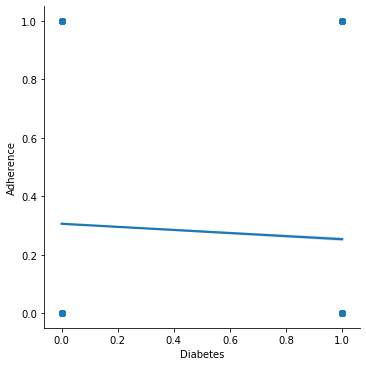

In [10]:
sns.lmplot(y="Adherence", x = 'Diabetes',data=new_df )

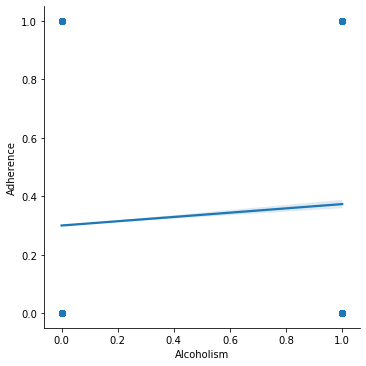

In [11]:
sns.lmplot(y="Adherence", x = 'Alcoholism',data=new_df )

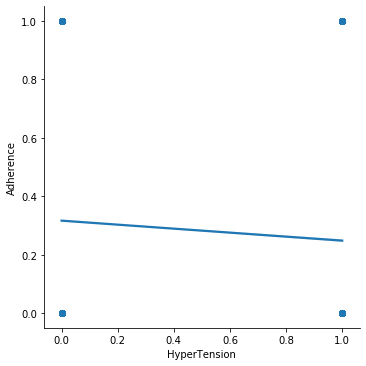

In [12]:
sns.lmplot(y="Adherence", x = 'HyperTension',data=new_df )

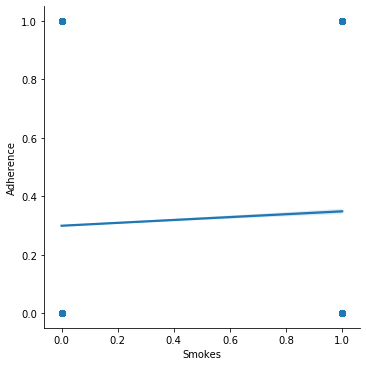

In [13]:
sns.lmplot(y="Adherence", x = 'Smokes',data=new_df )

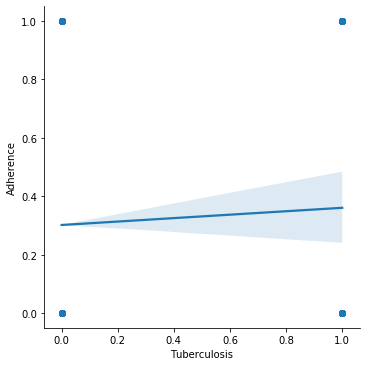

In [14]:
sns.lmplot(y="Adherence", x = 'Tuberculosis',data=new_df )

6167


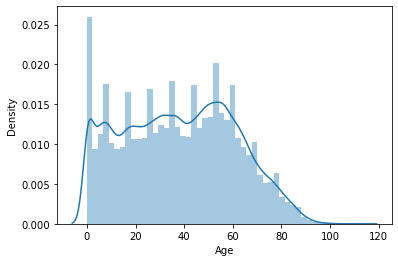

In [16]:
sns.distplot(new_df["Age"])
print((new_df['Age'] == 0).sum())
# 6167 records with missing age OR infants

In [17]:
# Lets investigate to see if infants are marked as alcoholics, smokers etc.
df[df['Age']==0].groupby(['Tuberculosis']).aggregate('sum')

,Age,Male_or_Not,Prescription_period,Diabetes,Alcoholism,HyperTension,Smokes,Sms_Reminder,Adherence
Tuberculosis,,,,,,,,,
0,0,3122,342878,0,0,0,0,3349,1763
1,0,0,28,0,0,0,0,0,2


Data doesn't have suspicious data points, which means that the Age 0 patients infact are infants , not missing data

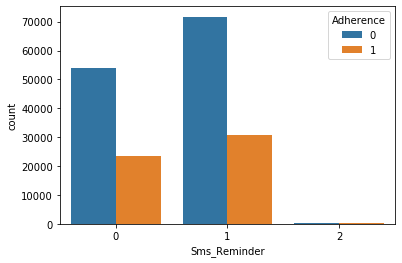

In [18]:
sns.countplot(x='Sms_Reminder', data=df, hue='Adherence')

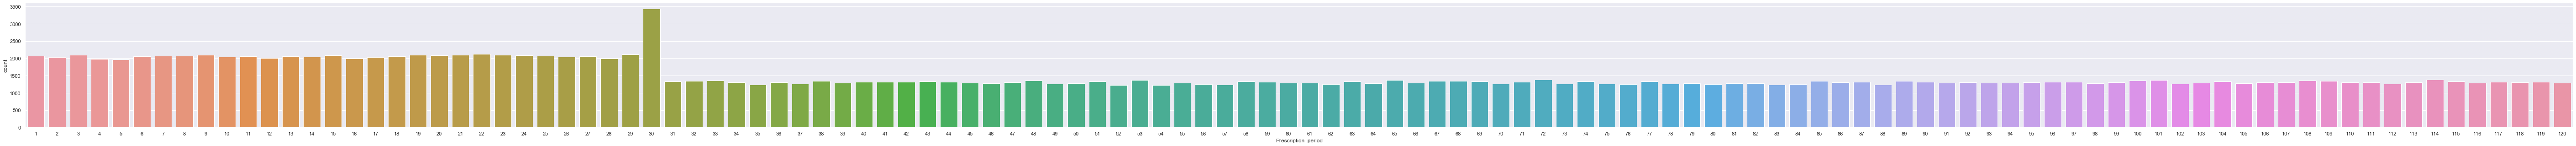

In [19]:
sns.set(rc={'figure.figsize':(100,5)}) 
sns.countplot(new_df["Prescription_period"])

In [20]:
new_df[new_df['Age']==0].groupby(['Male_or_Not']).aggregate('sum')

,Age,Prescription_period,Diabetes,Alcoholism,HyperTension,Smokes,Tuberculosis,Sms_Reminder,Adherence
Male_or_Not,,,,,,,,,
0,0,168131,0,0,0,0,2,1624,871
1,0,174775,0,0,0,0,0,1725,894


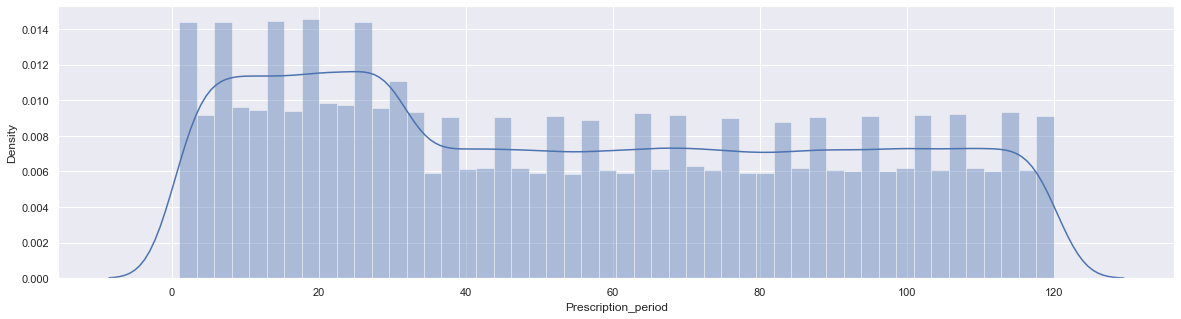

In [21]:
sns.set(rc={'figure.figsize':(20,5)}) 
sns.distplot(df["Prescription_period"])

Most of the prescriptions are of lesser number of days, which would be natural

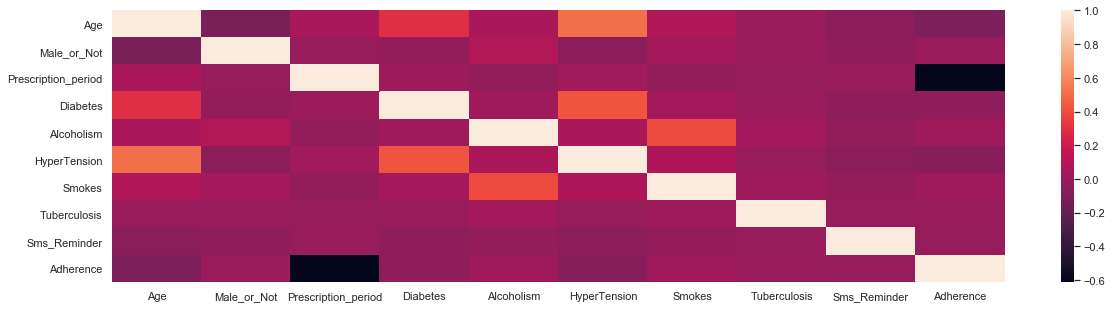

In [22]:
corr = new_df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [34]:
# Calculating VIF to check for correlation in numeric factors
from statsmodels.stats.outliers_influence import variance_inflation_factor
df_numeric = df._get_numeric_data()
df_numeric.head()
df_numeric.drop(['Adherence'],axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_numeric.values, i) for i in range(df_numeric.shape[1])]
vif["features"] = df_numeric.columns
print(vif.round(1))

   VIF Factor             features
0         3.9                  Age
1         1.4          Male_or_Not
2         2.9  Prescription_period
3         1.3             Diabetes
4         1.2           Alcoholism
5         1.9         HyperTension
6         1.3               Smokes
7         1.0         Tuberculosis
8         2.0         Sms_Reminder
9         1.5            Adherence


In [35]:
df.head()

,Age,Male_or_Not,Prescription_period,Diabetes,Alcoholism,HyperTension,Smokes,Tuberculosis,Sms_Reminder,Adherence
0,19,1,7,0,0,0,0,0,0,0
1,24,0,59,0,0,0,0,0,0,0
2,4,0,43,0,0,0,0,0,0,0
3,38,1,66,0,0,0,0,0,1,0
4,46,0,98,0,0,0,0,0,1,0


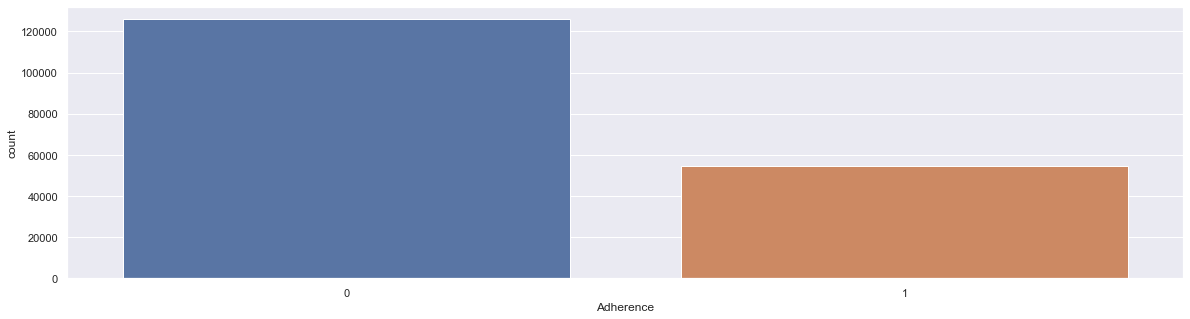

In [36]:
sns.countplot(x="Adherence", data=new_df)

The classes are inbalanced but they aren't severely imbalanced so we should be good

### Feature Scaling

In [37]:
# One hot encoding of SMS Reminder as it has 3 values
cat_vars=['Sms_Reminder']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df[var], prefix=var)
    data1=df.join(cat_list)
    df=data1
cat_vars=['Sms_Reminder']
data_vars=df.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

data_final=df[to_keep]

In [38]:
data_final.head()

,Age,Male_or_Not,Prescription_period,Diabetes,Alcoholism,HyperTension,Smokes,Tuberculosis,Adherence,Sms_Reminder_0,Sms_Reminder_1,Sms_Reminder_2
0,19,1,7,0,0,0,0,0,0,1,0,0
1,24,0,59,0,0,0,0,0,0,1,0,0
2,4,0,43,0,0,0,0,0,0,1,0,0
3,38,1,66,0,0,0,0,0,0,0,1,0
4,46,0,98,0,0,0,0,0,0,0,1,0


In [61]:
data_final_vars=data_final.columns.values.tolist()
y=['Adherence']
X=[i for i in data_final_vars if i not in y]
X=data_final[X]
y=data_final[y]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.88


In [66]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix of Test Data')
print(cm)

Confusion matrix of Test Data
[[34207  3632]
 [ 2851 13374]]


In [67]:
print('Precision and Recall (0 = NO and 1 = YES)')
print(classification_report(y_test, y_pred))

Precision and Recall (0 = NO and 1 = YES)
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     37839
           1       0.79      0.82      0.80     16225

    accuracy                           0.88     54064
   macro avg       0.85      0.86      0.86     54064
weighted avg       0.88      0.88      0.88     54064



# Decision Tree

In [69]:
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train, y_train)

y_pred = decision_tree_classifier.predict(X_test)
y_prob = decision_tree_classifier.predict_proba(X_test)
from sklearn.metrics import accuracy_score
print('Accuracy of decision tree classifier on test set: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Accuracy of decision tree classifier on test set: 0.85


In [70]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix of Test Data')
print(cm)
print('Precision and Recall (0 = NO and 1 = YES)')
print(classification_report(y_test, y_pred))

Confusion matrix of Test Data
[[33866  3973]
 [ 4163 12062]]
Precision and Recall (0 = NO and 1 = YES)
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     37839
           1       0.75      0.74      0.75     16225

    accuracy                           0.85     54064
   macro avg       0.82      0.82      0.82     54064
weighted avg       0.85      0.85      0.85     54064



In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [72]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
y_prob = rf_classifier.predict_proba(X_test)
from sklearn.metrics import accuracy_score
print('Accuracy of RF classifier on test set: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Accuracy of RF classifier on test set: 0.87


In [74]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix of Test Data')
print(cm)
print('Precision and Recall (0 = NO and 1 = YES)')
print(classification_report(y_test, y_pred))

Confusion matrix of Test Data
[[33811  4028]
 [ 3069 13156]]
Precision and Recall (0 = NO and 1 = YES)
              precision    recall  f1-score   support

           0       0.92      0.89      0.91     37839
           1       0.77      0.81      0.79     16225

    accuracy                           0.87     54064
   macro avg       0.84      0.85      0.85     54064
weighted avg       0.87      0.87      0.87     54064



Accuracy improved over Random Forest

In [ ]:
# Try this when you have gpu
# Build a pipeline object
pipe = Pipeline([
    ('clf', RandomForestClassifier(random_state=0, n_jobs=-1))
])

# Declare a hyperparameter grid
param_grid = {
    "clf__n_estimators": [500,700],
    "clf__max_depth": [10,20],
    "clf__max_features": ['auto']
}

# Perform grid search, fit it
# Used RepeatedStratifiedKFold for finding the best train and validation data
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1) 
grid_search_RF = GridSearchCV(pipe, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1000,scoring = 'accuracy')
grid_search_RF.fit(X_train, y_train.ravel())

Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [73]:
grid=grid_search_RF.best_params_
grid